# Building Sentiment Analysis models

Last updated : October 21th, 2022 

# Introduction

During this project, I will create an optimized Sentiment Analysis model based on a dataset created from Twitter reviews. This project will be completely created in Microsoft Azure Machine Learning Studio, and I will compare our model with the Microsoft Azure cognitive API service for Sentiment Analysis.

## 1. Data Preprocessing

We will first load and process our dataset.

### 1.1 Loading packages and the Dataset

In [1]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})
import dill

import os
import shutil

import tensorflow as tf

import sklearn

tf.get_logger().setLevel('ERROR')

In [2]:
meta = pd.read_csv('Data/articles_metadata.csv')

meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


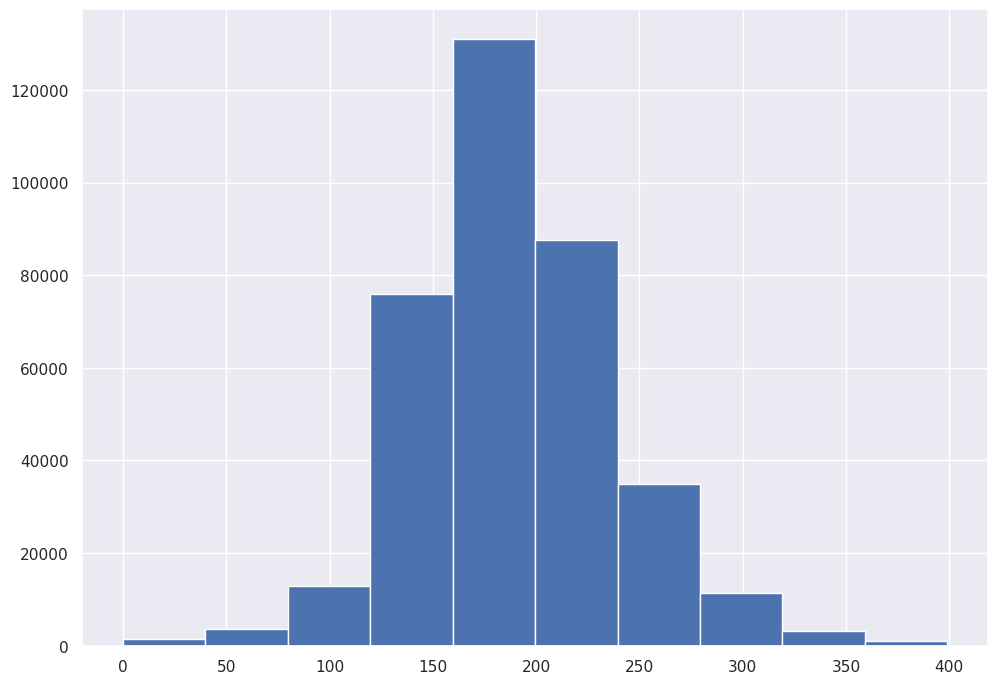

In [3]:
plt.hist(meta[meta.words_count<400].words_count)
plt.show()

In [4]:
len(meta[meta.words_count>= 400])

1218

In [5]:
print(len(meta.category_id.unique()))

meta.category_id.value_counts(normalize=True)

461


281    0.035207
375    0.027483
399    0.024857
412    0.023755
431    0.021313
         ...   
341    0.000003
121    0.000003
335    0.000003
131    0.000003
0      0.000003
Name: category_id, Length: 461, dtype: float64

In [6]:
#Testing that all article_id are unique
assert len(meta.article_id.unique()) == len(meta)

In [7]:
len(meta.publisher_id.unique())
# only 1 publisher, we can delete this column

meta.drop(columns={"publisher_id"}, inplace=True)

meta.head()

,article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162


In [8]:
sample = pd.read_csv('Data/clicks_sample.csv')

sample.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [9]:
CLICK_PATH = 'Data/clicks/'

click_files = [CLICK_PATH + f for f in os.listdir(CLICK_PATH)]

click_files.sort()

print("Number of click files: ", len(click_files))

print("Concatenating click files...")

click_dfs = [pd.read_csv(x) for x in click_files]

click_df = pd.concat(click_dfs, axis=0, ignore_index=True)

print(click_df.shape)
click_df.head()

Number of click files:  385
Concatenating click files...
(2988181, 12)


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [10]:
#Collaborative filtering does not require data about users apart from the article they visit
cf_df = click_df.merge(meta, left_on='click_article_id', right_on='article_id', how='inner')

cf_df = cf_df[['user_id', 'article_id', 'category_id']]
print(cf_df.shape)
cf_df.head()

(2988181, 3)


,user_id,article_id,category_id
0,0,157541,281
1,20,157541,281
2,44,157541,281
3,45,157541,281
4,76,157541,281


In [11]:
#Creating user engagement matrix
engagement = cf_df.groupby(['user_id','category_id']).size().reset_index()

engagement.rename(columns={0: 'rating'}, inplace=True)

engagement.head()

,user_id,category_id,rating
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1


In [12]:
print(engagement.rating.describe())

engagement[engagement.rating > 200]

#Some users are particularly active, but the average engagement rating is only 1.6

count    1.882302e+06
mean     1.587514e+00
std      1.921600e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.350000e+02
Name: rating, dtype: float64


,user_id,category_id,rating
132132,11521,398,348
172550,15275,226,211
172551,15275,228,535
179180,15867,375,256
668157,67935,428,303


In [13]:
len(engagement[engagement.rating > 10])
#Only 10 thousand users out of 1.8 million with an engagement of more than 10 on a category



10547